# Download Daymet

Daymet provides gridded meteorological data for North American at 1km spatial resolution with daily timestep from 1980 ~ present. [website](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1328) and [user guide](https://daac.ornl.gov/DAYMET/guides/Daymet_V3_CFMosaics.html)

Available variables:

| Variable | Description (units) |
| ---- | ---- |
| tmax | Daily maximum 2-meter air temperature (°C) |
| tmin | Daily minimum 2-meter air temperature (°C) |
| prcp | Daily total precipitation (mm/day) |
| srad | Incident shortwave radiation flux density (W/m2) |
| vp   | Water vapor pressure (Pa) |
| swe  | Snow water equivalent (kg/m2) |
| dayl | Duration of the daylight period (seconds) |

Notes:
 - The Daymet calendar is based on a standard calendar year. <span style="color:blue;"> All Daymet years, including leap years, have 365 days. Keep this in mind during post-processing of model results!</span>  For leap years, the Daymet database includes leap day (February 29) and values for December 31 are discarded from leap years to maintain a 365-day year.
 
 - DayMet's incident shortwave radiation is the "daylit" radiation.  To get the daily average radiation, one must multiply by daylit fraction, given by dayl / 86400.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [2]:
import logging,yaml
import numpy as np
import rasterio
import fiona
import os
import datetime 

import watershed_workflow
import watershed_workflow.ui
import watershed_workflow.sources.manager_daymet
import watershed_workflow.daymet
import watershed_workflow.io

watershed_workflow.ui.setup_logging(1,None)

In [3]:
watershed_workflow.config.set_data_directory('../../data')

In [4]:
#watershed_name = 'CoalCreek'
watershed_name = 'FranklinBasin'
watershed_shapefile = f'../../data/examples/{watershed_name}/sources/shapefile/{watershed_name}.shp'
config_fname = f'../../data/examples/{watershed_name}/processed/config.yaml'

In [5]:
# Load the dictionary from the file
with open(config_fname, 'r') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [6]:
# dates are in YYYY-MM-DD
# start and end of simulation -- one year of simulation that is in both the MODIS and DayMet dataset ranges
start_date = config['start_date']
end_date = config['end_date']
origin_date = config['origin_date']
logging.info(f"Daymet start date:{start_date} and end date:{end_date}. All times are relative to {origin_date}")

2025-04-21 23:56:44,255 - root - INFO: Daymet start date:2021-10-1 and end date:2023-10-1. All times are relative to 1980-1-1


## import watershed

In [7]:
crs, watershed = watershed_workflow.get_split_form_shapes(watershed_shapefile)
logging.info(f'crs: {crs}')

bounds = watershed.exterior().bounds
print(bounds)
print(bounds[2] - bounds[0], bounds[3] - bounds[1])

2025-04-21 23:56:44,269 - root - INFO: 
2025-04-21 23:56:44,270 - root - INFO: Loading shapes
2025-04-21 23:56:44,270 - root - INFO: ------------------------------
2025-04-21 23:56:44,271 - root - INFO: Loading file: '../../data/examples/FranklinBasin/sources/shapefile/FranklinBasin.shp'
2025-04-21 23:56:44,314 - root - INFO: ... found 1 shapes
2025-04-21 23:56:44,315 - root - INFO: Converting to shapely
2025-04-21 23:56:44,319 - root - INFO:  ... done
2025-04-21 23:56:44,320 - root - INFO: Removing holes on 1 polygons
2025-04-21 23:56:44,321 - root - INFO:   -- removed interior
2025-04-21 23:56:44,323 - root - INFO:   -- union
2025-04-21 23:56:44,323 - root - INFO: Parsing 1 components for holes
2025-04-21 23:56:44,324 - root - INFO:   -- complete
2025-04-21 23:56:44,326 - root - INFO: crs: epsg:26912


(445019.02273755515, 4644390.694223704, 453779.02357031987, 4655750.695492925)
8760.000832764723 11360.001269221306


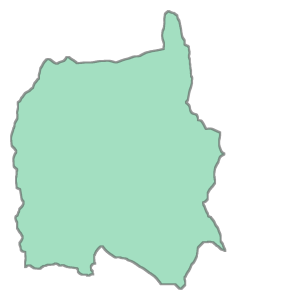

In [8]:
watershed.exterior()

## Download

returned raw data has `dim(nband, ncol, nrow)`

In [9]:
# setting vars = None to download all available variables
source = watershed_workflow.sources.manager_daymet.FileManagerDaymet()
data = source.get_data(bounds, crs, start = start_date, end = end_date, buffer=0.02)

2025-04-21 23:56:44,389 - root - INFO: Collecting DayMet file to tile bounds: [-111.6844, 41.9296, -111.5377, 42.0725]
2025-04-21 23:56:44,391 - root - INFO:   Using existing: ../../data/meteorology/daymet/daymet_tmin_2021_42.0725x-111.6844_41.9296x-111.5377.nc
2025-04-21 23:56:44,391 - root - INFO: Collecting DayMet file to tile bounds: [-111.6844, 41.9296, -111.5377, 42.0725]
2025-04-21 23:56:44,392 - root - INFO:   Using existing: ../../data/meteorology/daymet/daymet_tmin_2022_42.0725x-111.6844_41.9296x-111.5377.nc
2025-04-21 23:56:44,392 - root - INFO: Collecting DayMet file to tile bounds: [-111.6844, 41.9296, -111.5377, 42.0725]
2025-04-21 23:56:44,393 - root - INFO:   Using existing: ../../data/meteorology/daymet/daymet_tmin_2023_42.0725x-111.6844_41.9296x-111.5377.nc
2025-04-21 23:56:44,393 - root - INFO: Collecting DayMet file to tile bounds: [-111.6844, 41.9296, -111.5377, 42.0725]
2025-04-21 23:56:44,394 - root - INFO:   Using existing: ../../data/meteorology/daymet/daymet_t

## Reproject Daymet CRS

Reproject daymet CRS to the same as the watershed. This is necessary if watershed meshes are using watershed CRS.

In [10]:
# this is a workaround, need to update the wrap.py to comment out  'dtype': src_profile['dtype']
data.profile.update({'dtype': data.data['prcp'].dtype})

In [11]:
data_warped = watershed_workflow.warp.dataset(data, dst_crs=crs)

## plot Daymet

/opt/conda/envs/watershed_workflow/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
2025-04-21 23:56:44,936 - root - INFO: BOUNDS: (-921250.0, 3000.0, -907250.0, 19000.0)
2025-04-21 23:56:44,945 - root - INFO: BOUNDS: (441252.77657918393, 4640816.157085467, 457961.9581733637, 4659491.124749551)


Text(0.5, 1.0, 'Reprojected Daymet')

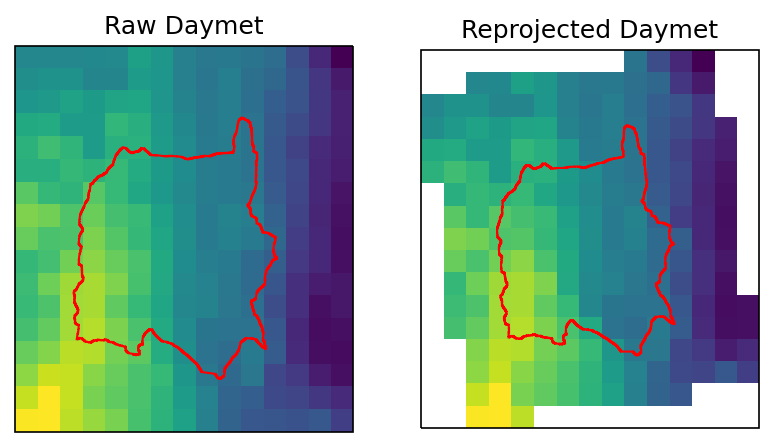

In [12]:
ivar = 'tmax'
islice = 100
daymet_crs = watershed_workflow.crs.daymet_crs()

fig = plt.figure()
ax1 = watershed_workflow.plot.get_ax(daymet_crs, fig, 1, 2, 1)
ax2 = watershed_workflow.plot.get_ax(crs, fig, 1, 2, 2)

watershed_ext_daymet = watershed_workflow.warp.shply(watershed.exterior(),
                                                     crs, daymet_crs)
watershed_workflow.plot.raster(data[ivar].profile, data[ivar].data[islice,:,:], ax1)
watershed_workflow.plot.shply(watershed_ext_daymet, daymet_crs, ax=ax1, color='r')

watershed_workflow.plot.raster(data_warped[ivar].profile, data_warped[ivar].data[islice,:,:], ax2)
watershed_workflow.plot.hucs(watershed, crs, ax=ax2, color='r')

ax1.set_title("Raw Daymet")
ax2.set_title("Reprojected Daymet")



# save daymet

## Write data to HDF5

This will write daymet in a format that ATS can read. E.g., this will calculate mean air temperature, convert units, partition precipitation into rain and snow based on mean temp (<span style="color:blue;"> T_air=0 degC is used for the partitioning of rain and snow! </span> This can be highly variable based on area. For more information on rain/snow partition, see this [RainOrSnow website](https://www.rainorsnow.org/report-backs/snowabovefreezing)), and so on.

- dout has dims of `(ntime, nrow, ncol)` or `(ntime, ny, nx)`

In [13]:
met_data = watershed_workflow.daymet.convertToATS(data_warped)

config['daymet_filename'] = os.path.join('..', '..', 'data', 'examples', watershed_name, 'processed','watershed_daymet_raw.h5')
attrs = watershed_workflow.daymet.getAttributes(bounds, start_date, end_date)
attrs['name']="Daymet forcing reformatted for ats modeling"

watershed_workflow.io.write_dataset_to_hdf5(
    filename=config['daymet_filename'],
    attributes= attrs,
    dataset=met_data,
    time0 = origin_date
)

2025-04-21 23:56:45,058 - root - INFO: Converting to ATS met input
2025-04-21 23:56:45,064 - root - INFO: Writing HDF5 file: ../../data/examples/FranklinBasin/processed/watershed_daymet_raw.h5


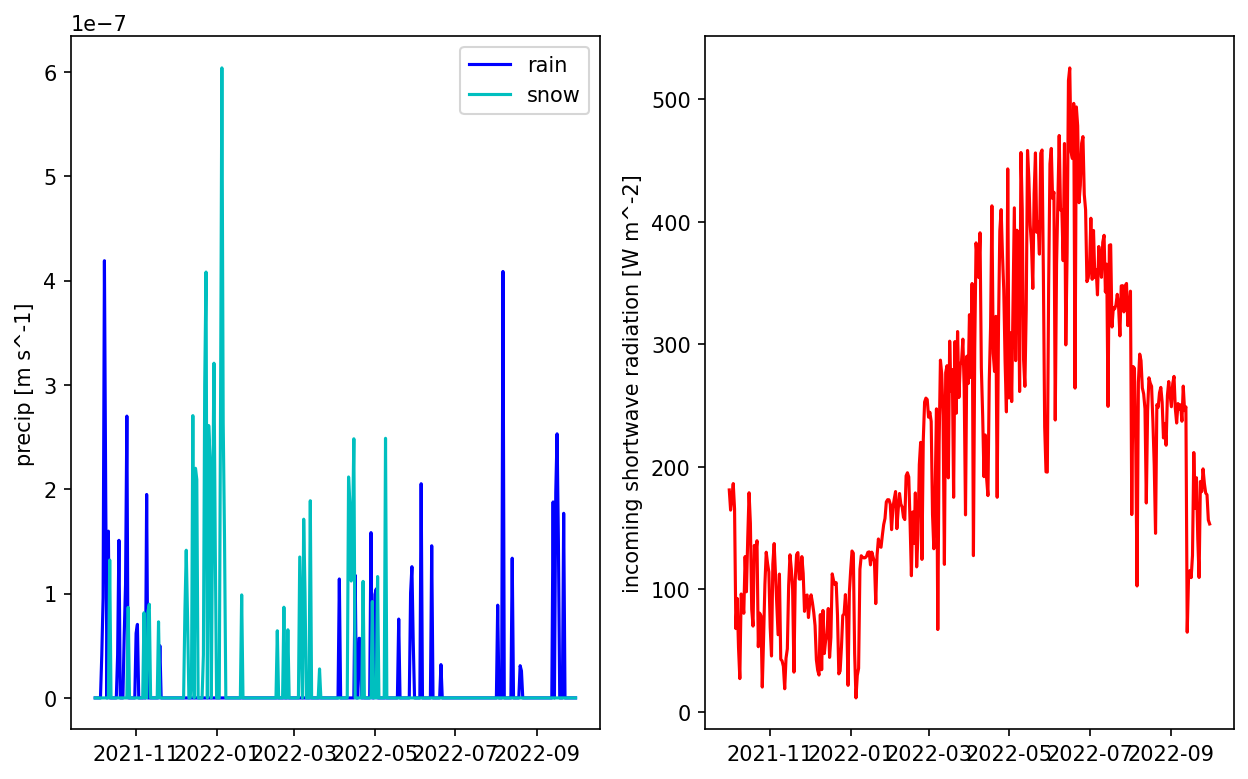

In [14]:
# plot one pixel as a function of time
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(121)

times = np.array([datetime.datetime(*t.timetuple()[0:6]) for t in met_data.times])
prain = met_data['precipitation rain [m s^-1]'].data[:,5,5]
psnow = met_data['precipitation snow [m SWE s^-1]'].data[:,5,5]

ax.plot(times[0:365], prain[0:365], 'b', label='rain')
ax.plot(times[0:365], psnow[0:365], 'c', label='snow')
ax.set_ylabel('precip [m s^-1]')
ax.legend()

ax = fig.add_subplot(122)
qswin = met_data['incoming shortwave radiation [W m^-2]'].data[:,5,5]
ax.plot(times[0:365], qswin[0:365], 'r')
ax.set_ylabel('incoming shortwave radiation [W m^-2]')


plt.show()

## Write typical Daymet

This will average days, smooths the forcing and generate a "typical year" data, then looped 10 years. The dataset will be used during cyclic spinup.

In [15]:
# compute the typical year of the _raw_ data
# note that we set interpolate to False, since met_data is already daily on a noleap calendar
nyears_cyclic_steadystate = config['nyears_cyclic_steadystate']

data_smooth = watershed_workflow.datasets.computeAverageYear(data_warped, output_nyears=nyears_cyclic_steadystate, smooth=True, 
                                                                 smooth_kwargs=dict(window_length=181, polyorder=2),
                                                                 interpolate=False)

# convert that to ATS
met_data_smooth = watershed_workflow.daymet.convertToATS(data_smooth)

2025-04-21 23:56:46,204 - root - INFO: Converting to ATS met input


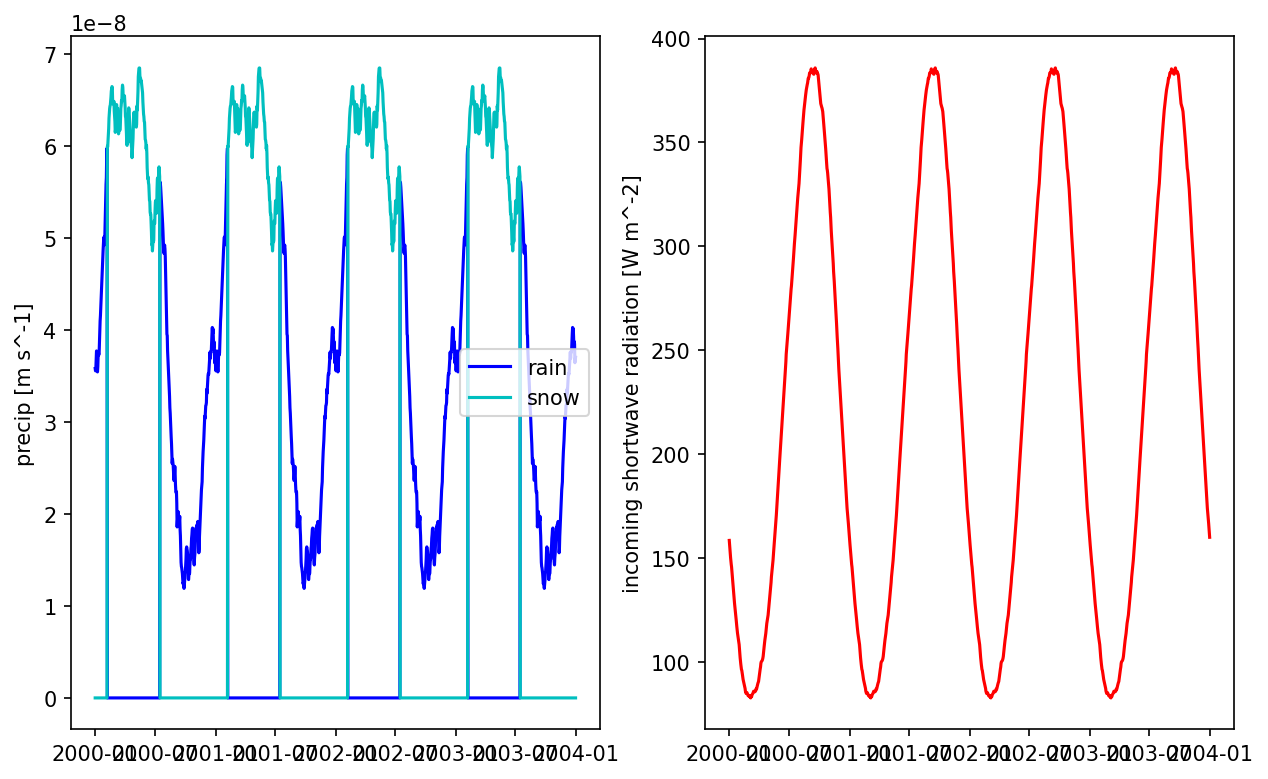

In [16]:
# plot the smoothed precip result
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(121)

times = np.array([datetime.datetime(*t.timetuple()[0:6]) for t in met_data_smooth.times])
prain = met_data_smooth['precipitation rain [m s^-1]'].data[:,5,5]
psnow = met_data_smooth['precipitation snow [m SWE s^-1]'].data[:,5,5]
ax.plot(times, prain, 'b', label='rain')
ax.plot(times, psnow, 'c', label='snow')

ax.set_ylabel('precip [m s^-1]')
ax.legend()

ax = fig.add_subplot(122)
qswin = met_data_smooth['incoming shortwave radiation [W m^-2]'].data[:,5,5]
ax.plot(times, qswin, 'r')
ax.set_ylabel('incoming shortwave radiation [W m^-2]')
plt.show()

In [17]:
# often smoothing precip like that is a bad idea -- you now have every day misting with low intensity rain which can result in a ton of interception
# and canopy evaporation and no transpiration.  Another approach is to just take the median total rainfall year and repeat that year multiple times.
precip_raw = data_warped['prcp'].data
shape_xy = precip_raw.shape[1:]
precip_raw = precip_raw.reshape((-1, 365,)+shape_xy)
annual_precip_raw = precip_raw.sum(axis=(1,2,3))

# note -- don't use np.median here... for even number of years it will not appear.  Instead, sort and talk the halfway point
median_i = sorted(((i,v) for (i,v) in enumerate(annual_precip_raw)), key=lambda x : x[1])[len(annual_precip_raw)//2][0]
typical_precip_raw = precip_raw[median_i]
data_smooth['prcp'] = np.tile(typical_precip_raw, (nyears_cyclic_steadystate,1,1))

# np.tile(precip_raw[median_i], (2,1,1))
# data_smooth['prcp'] = typical_precip_raw

# convert that to ATS
met_data_smooth = watershed_workflow.daymet.convertToATS(data_smooth)

2025-04-21 23:56:46,494 - root - INFO: Converting to ATS met input


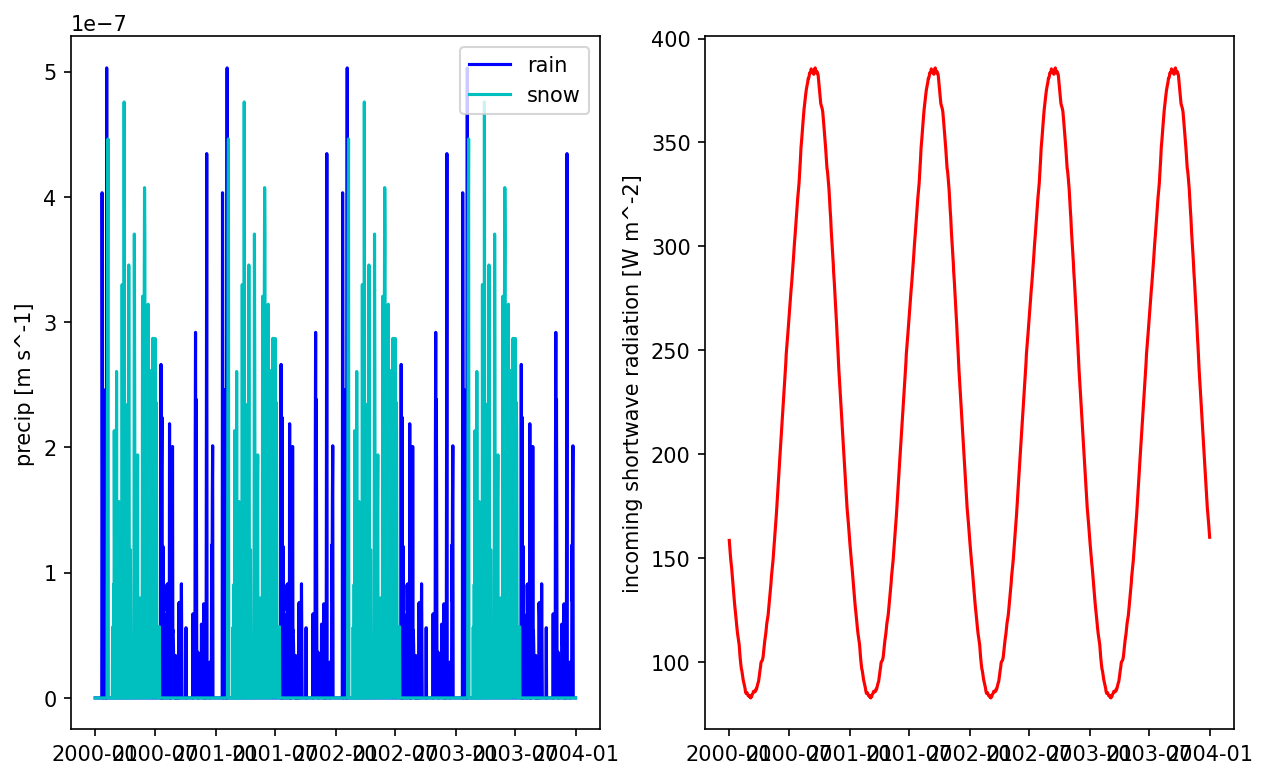

In [18]:
# plot the smoothed precip result
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(121)

times = np.array([datetime.datetime(*t.timetuple()[0:6]) for t in met_data_smooth.times])
prain = met_data_smooth['precipitation rain [m s^-1]'].data[:,5,5]
psnow = met_data_smooth['precipitation snow [m SWE s^-1]'].data[:,5,5]
ax.plot(times, prain, 'b', label='rain')
ax.plot(times, psnow, 'c', label='snow')

ax.set_ylabel('precip [m s^-1]')
ax.legend()

ax = fig.add_subplot(122)
qswin = met_data_smooth['incoming shortwave radiation [W m^-2]'].data[:,5,5]
ax.plot(times, qswin, 'r')
ax.set_ylabel('incoming shortwave radiation [W m^-2]')
plt.show()

In [19]:
# write to disk
config['daymet_typical_filename'] = os.path.join('..', '..', 'data', 'examples', watershed_name, 'processed','watershed_daymet_typical.h5')

attrs = watershed_workflow.daymet.getAttributes(bounds, start_date, end_date)
# attrs['name']="Daymet forcing reformatted for ats modeling"
attrs['name']=f"{nyears_cyclic_steadystate}-yrs typical Daymet forcing generated using data from {start_date} to {end_date}"

watershed_workflow.io.write_dataset_to_hdf5(
    filename=config['daymet_typical_filename'],
    dataset=met_data_smooth,
    attributes= attrs,
    time0 = None) # use the first date as the time0, relative time to be consistent with start time in xml file

2025-04-21 23:56:46,769 - root - INFO: Writing HDF5 file: ../../data/examples/FranklinBasin/processed/watershed_daymet_typical.h5


2025-04-21 23:56:48,343 - root - INFO: BOUNDS: (441252.77657918393, 4640816.157085467, 457961.9581733637, 4659491.124749551)
2025-04-21 23:56:48,348 - root - INFO: BOUNDS: (441252.77657918393, 4640816.157085467, 457961.9581733637, 4659491.124749551)


Text(0.5, 1.0, 'Smoothed Daymet')

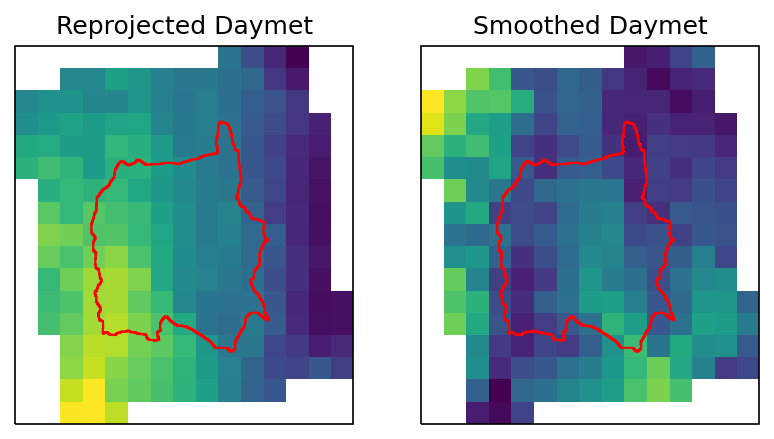

In [20]:
ivar = 'tmax'
islice = 100
# daymet_crs = watershed_workflow.crs.daymet_crs()

fig = plt.figure()
ax1 = watershed_workflow.plot.get_ax(crs, fig, 1, 2, 1)
ax2 = watershed_workflow.plot.get_ax(crs, fig, 1, 2, 2)

# watershed_ext_daymet = watershed_workflow.warp.shply(watershed.exterior(),
#                                                      crs, daymet_crs)
# watershed_workflow.plot.raster(data_warped[ivar].profile, data_warped[ivar].data[islice,:,:], ax1)
# watershed_workflow.plot.shply(watershed_ext_daymet, daymet_crs, ax=ax1, color='r')

watershed_workflow.plot.raster(data_warped[ivar].profile, data_warped[ivar].data[islice,:,:], ax1)
watershed_workflow.plot.hucs(watershed, crs, ax=ax1, color='r')

watershed_workflow.plot.raster(data_smooth[ivar].profile, data_smooth[ivar].data[islice,:,:], ax2)
watershed_workflow.plot.hucs(watershed, crs, ax=ax2, color='r')

ax1.set_title("Reprojected Daymet")
ax2.set_title("Smoothed Daymet")



Get mean precipitation for spinup

In [21]:
# calculate the basin-averaged, annual-averaged precip rate
precip_total = met_data.data['precipitation rain [m s^-1]'] + met_data.data['precipitation snow [m SWE s^-1]']
mean_precip = precip_total.mean()
config['mean_precip [m s^-1]'] = float(mean_precip)
logging.info(f'Mean annual precip rate [m s^-1] = {mean_precip}')

2025-04-21 23:56:48,427 - root - INFO: Mean annual precip rate [m s^-1] = 2.9638164538918578e-08


In [22]:
with open(config_fname, 'w') as file:
    yaml.dump(config, file)